# 1. 2020년 올림픽 게임에 대한 위키피디아 데이터 수집

이 프로젝트의 아이디어는 제공된 텍스트의 몇 단락을 기반으로 질문 응답 모델을 만드는 것입니다. 기본 GPT-3 모델은 답변이 문단 내에 포함되어 있을 때 질문에 답하는 데 능숙하지만, 답변이 포함되어 있지 않으면 기본 모델은 어쨌든 답변을 하려고 최선을 다하는 경향이 있어 종종 잘못된 답변으로 이어집니다.

충분한 컨텍스트가 있는 경우에만 질문에 답변하는 모델을 만들기 위해 먼저 텍스트 단락을 기반으로 질문 및 답변 데이터 세트를 만듭니다. 답변이 있을 때만 응답하도록 모델을 훈련시키기 위해 질문이 컨텍스트와 일치하지 않는 적대적 예제도 추가합니다. 이러한 경우 모델에 "질문에 답변하기에 충분한 컨텍스트가 없습니다"를 출력하도록 요청합니다.

이 작업은 세 개의 노트북에서 수행할 것입니다.:
1. 첫 번째(이) 노트북은 GPT-3가 사전 훈련 동안 보지 못한 최근 데이터 수집에 중점을 둡니다. 우리는 2020년 올림픽(실제로 2021년 여름에 개최됨)이라는 주제를 선택하고 713개의 고유 페이지를 다운로드했습니다. 우리는 데이터 세트를 개별 섹션으로 구성했으며, 이는 질문을 묻고 답하기 위한 컨텍스트 역할을 합니다.
2. [두 번째 노트북](olympics-2-create-qa.ipynb)은 Davinci-instruct를 활용하여 Wikipedia 섹션을 기반으로 몇 가지 질문을 하고 해당 섹션을 기반으로 해당 질문에 답변합니다.
3. [세 번째 노트북](olympics-3-train-qa.ipynb)은 컨텍스트, 질문 및 답변 쌍의 데이터 세트를 활용하여 해당 컨텍스트에서 질문이 생성되지 않은 적대적 질문 및 컨텍스트 쌍을 추가로 생성합니다. 이러한 경우 모델은 "질문에 대답하기에 충분한 컨텍스트가 없습니다"라고 대답하도록 프롬프트됩니다. 또한 문맥을 기반으로 질문에 대한 답변이 가능한지 여부를 예측하는 판별자 모델을 훈련할 것입니다.

## 1.1 위키피디아 API를 사용한 데이터 추출
데이터를 추출하는 데 약 30분이 소요되며 처리에는 그 정도의 시간이 소요될 것입니다.

재귀 호출의 예

In [ ]:
def foo():
    print('foo()')
    
for i in range(5):
    foo()

In [ ]:
def foo(n):
    if n==0 :
        return
    print('foo()')
    foo(n-1)
    
foo(5)

In [ ]:
titles = ['2020 Summer Olympics']
titles = [title for title in titles if '2020' in title and 'olympi' in title.lower()]

# for title in titles:
#     if '2020' in title and 'olympi' in title.lower():
#         print(title)

print(titles)

In [ ]:
titles = ['Kosovo at the 2020 Summer Olympics', '2020 Summer Olympics']
titles_so_far = set(['2020 Summer Olympics'])
titles = list(set(titles) - titles_so_far)
print('titles=' , titles)

In [1]:
import pandas as pd
import wikipedia


def filter_olympic_2020_titles(titles):
    """
    타이틀 목록이 주어지면 2020년에 개최되는 올림픽 게임과 관련된 타이틀을 가져옵니다.
    """
    titles = [title for title in titles if '2020' in title and 'olympi' in title.lower()]
    
    return titles

def get_wiki_page(title):
    """
    제목이 지정된 위키피디아 페이지 가져오기
    """
    try:
        return wikipedia.page(title)
    except wikipedia.exceptions.DisambiguationError as e:
        return wikipedia.page(e.options[0])
    except wikipedia.exceptions.PageError as e:
        return None

def recursively_find_all_pages(n, titles, titles_so_far=set()):
    """
    목록에서 Wikipedia 제목에 연결된 모든 페이지를 재귀적으로 찾습니다.
    """
   
    all_pages = []
    
#     if n==0 : 
#         return  all_pages
    
#     print('set(titles)=' , set(titles))
    titles = list(set(titles) - titles_so_far)
#     print('titles=' , titles)
    titles = filter_olympic_2020_titles(titles)
#     print('titles=' , titles)
    titles_so_far.update(titles)
#     print(titles_so_far)
    for title in titles:
        page = get_wiki_page(title)
#         print(page.links)
        if page is None:
            continue
        all_pages.append(page)
#         print(all_pages)

#         print(page.links)
#         print(len(page.links))
        new_pages = recursively_find_all_pages(n-1, page.links, titles_so_far)
#         for pg in new_pages:
#             if pg.title not in [p.title for p in all_pages]:
#                 all_pages.append(pg)
#         titles_so_far.update(page.links)
    return all_pages


pages = recursively_find_all_pages(2, ["2020 Summer Olympics"])
len(pages)

KeyboardInterrupt: 

## 1.2 Wikipedia 페이지 필터링 및 제목별로 섹션 분할
텍스트 정보를 포함할 가능성이 없는 섹션을 제거하고 각 섹션이 토큰 제한보다 길지 않은지 확인합니다.

In [12]:
a = [1,2,3,4,5]

print(a.pop(0))
print(a)

1
[2, 3, 4, 5]


In [29]:

import re
from typing import Set
from transformers import GPT2TokenizerFast

import numpy as np
from nltk.tokenize import sent_tokenize

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    """문자열의 토큰 수 계산"""
    return len(tokenizer.encode(text))

def reduce_long(
    long_text: str, long_text_tokens: bool = False, max_len: int = 590
) -> str:
    """
    잠재적으로 문장 끝을 잘라 긴 텍스트를 최대 `max_len` 토큰으로 줄입니다.
    """
    if not long_text_tokens:
        long_text_tokens = count_tokens(long_text)
    if long_text_tokens > max_len:
        sentences = sent_tokenize(long_text.replace("\n", " "))
        ntokens = 0
        for i, sentence in enumerate(sentences):
            ntokens += 1 + count_tokens(sentence)
            if ntokens > max_len:
                return ". ".join(sentences[:i][:-1]) + "."

    return long_text

discard_categories = ['See also', 'References', 'External links', 'Further reading', "Footnotes",
    "Bibliography", "Sources", "Citations", "Literature", "Footnotes", "Notes and references",
    "Photo gallery", "Works cited", "Photos", "Gallery", "Notes", "References and sources",
    "References and notes",]


def extract_sections(
    wiki_text: str,
    title: str,
    max_len: int = 1500,
    discard_categories: Set[str] = discard_categories,
) -> str:
    """
    참조 및 기타 낮은 정보 섹션을 버리고 Wikipedia 페이지의 섹션을 추출합니다.
    """
    if len(wiki_text) == 0:
        return []

    # 모든 제목과 해당 내용 찾기
    headings = re.findall("==+ .* ==+", wiki_text)
#     print(wiki_text)
#     print(headings)
    
    for heading in headings:
        wiki_text = wiki_text.replace(heading, "==+ !! ==+")
        
#     print(wiki_text)
    contents = wiki_text.split("==+ !! ==+")
    contents = [c.strip() for c in contents]
    
#     print(contents)
    assert len(headings) == len(contents) - 1

#     print(contents)
    cont = contents.pop(0).strip()
#     print(contents)
#     print(cont)
    
    outputs = [(title, "Summary", cont, count_tokens(cont)+4)]
#     print(outputs)
    
    # 트리 구조를 고려하여 폐기 범주 폐기
    max_level = 100
    keep_group_level = max_level
    remove_group_level = max_level
    nheadings, ncontents = [], []
    for heading, content in zip(headings, contents):
        plain_heading = " ".join(heading.split(" ")[1:-1])
#         print(plain_heading)
#         print(heading.split(" "))
#         print(heading.split(" ")[0])
        num_equals = len(heading.split(" ")[0])
#         print(num_equals)
        if num_equals <= keep_group_level:
            keep_group_level = max_level

        if num_equals > remove_group_level:
            if (
                num_equals <= keep_group_level
            ):
                continue
        keep_group_level = max_level
        if plain_heading in discard_categories:
            remove_group_level = num_equals
            keep_group_level = max_level
            continue
        nheadings.append(heading.replace("=", "").strip())
#         print("nheadings=",nheadings)
        ncontents.append(content)
        remove_group_level = max_level

#     print("nheadings=", nheadings)
#     print("ncontents=", ncontents)
    # 각 섹션의 토큰 계산
    
#     print(count_tokens(" ".join(nheadings[4].split(" ")[1:-1])))
    
    ncontent_ntokens = [
        count_tokens(c)
        + 3
        + count_tokens(" ".join(h.split(" ")[1:-1]))
        - (1 if len(c) == 0 else 0)
        for h, c in zip(nheadings, ncontents)
    ]
    
#     print(ncontent_ntokens)

    # (title, section_name, content, number of tokens)의 튜플을 만듭니다.
    outputs += [(title, h, c, t) if t<max_len 
                else (title, h, reduce_long(c, max_len), count_tokens(reduce_long(c,max_len))) 
                    for h, c, t in zip(nheadings, ncontents, ncontent_ntokens)]
    
    return outputs

# 섹션으로 처리되는 예시 페이지
bermuda_page = get_wiki_page('Bermuda at the 2020 Summer Olympics')
# print(bermuda_page)
# print(bermuda_page.title)
# print(bermuda_page.content)
ber = extract_sections(bermuda_page.content, bermuda_page.title)

print(ber)

# 예시 섹션
ber[-1]


[('Bermuda at the 2020 Summer Olympics', 'Summary', "Bermuda competed at the 2020 Summer Olympics in Tokyo. Originally scheduled to take place from 24 July to 9 August 2020, the Games had been postponed to 23 July to 8 August 2021, because of the COVID-19 pandemic. Since the nation's official debut in 1936, Bermudian athletes have appeared in every edition of the Summer Olympic Games, but did not attend the 1980 Summer Olympics in Moscow because of the nation's support for the US-led boycott.\nThe first ever gold medal for Bermuda was won by triathlete Flora Duffy.", 117), ('Bermuda at the 2020 Summer Olympics', 'Medalists', '', 2), ('Bermuda at the 2020 Summer Olympics', 'Competitors', 'The following is the list of number of competitors in the Games.', 16), ('Bermuda at the 2020 Summer Olympics', 'Rowing', "Bermuda qualified one boat in the men's single sculls for the Games by finishing third in the B-final and securing the second of five berths available at the 2021 FISA Americas Oly

('Bermuda at the 2020 Summer Olympics',
 'Equestrian',
 "Bermuda entered one dressage rider into the Olympic competition by finishing in the top four, outside the group selection, of the individual FEI Olympic Rankings for Groups D and E (North, Central, and South America), marking the country's recurrence to the sport after an eight-year absence. The quota was later withdrawn, following an injury of Annabelle Collins' main horse Joyero and a failure to obtain minimum eligibility requirements (MER) aboard a new horse Chuppy Checker.",
 104)

### 1.2.1 데이터 세트를 만들고 토큰이 40개 미만인 섹션은 필터링합니다. 해당 섹션에는 좋은 질문을 하기에 충분한 컨텍스트가 포함되어 있지 않기 때문입니다.

In [ ]:
res = []
for page in pages:
    res += extract_sections(page.content, page.title)
df = pd.DataFrame(res, columns=["title", "heading", "content", "tokens"])
df = df[df.tokens>40]
df = df.drop_duplicates(['title','heading'])
df = df.reset_index().drop('index',axis=1) # reset index
df.head()

### 섹션 데이터 세트 저장
[다음 노트북](olympics-2-create-qa.ipynb)을 위해 섹션 데이터 세트를 저장합니다.

In [ ]:
df.to_csv('olympics-data/olympics_sections.csv', index=False)

## 1.3 (선택 사항) 데이터 탐색

In [36]:
df = pd.read_csv('olympics-data/olympics_sections.csv')

In [37]:
df.title.value_counts().head()

Concerns and controversies at the 2020 Summer Olympics    51
Great Britain at the 2020 Summer Olympics                 46
United States at the 2020 Summer Olympics                 43
Australia at the 2020 Summer Olympics                     39
Canada at the 2020 Summer Olympics                        39
Name: title, dtype: int64

2020년 동계 올림픽과 하계 올림픽이 있는 것 같습니다. 2020년 하계 올림픽에만 관심이 있음에도 불구하고 데이터 세트에 약간의 모호성과 노이즈를 남기기로 결정했습니다.

In [38]:
df.title.str.contains('Summer').value_counts()

True     3669
False     298
Name: title, dtype: int64

In [39]:
df.title.str.contains('Winter').value_counts()

False    3865
True      102
Name: title, dtype: int64

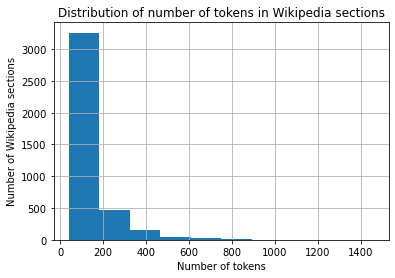

In [40]:
import pandas as pd
from matplotlib import pyplot as plt

df = pd.read_csv('olympics-data/olympics_sections.csv')
df[['tokens']].hist()
# 축 설명 및 제목 추가
plt.xlabel('Number of tokens')
plt.ylabel('Number of Wikipedia sections')
plt.title('Distribution of number of tokens in Wikipedia sections')
plt.show()

대부분의 섹션이 상당히 짧다는 것을 알 수 있습니다(500개 미만의 토큰).